# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
# for i in range(1, 6):                                      # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
from collections import deque
import matplotlib.pyplot as plt
import torch
%matplotlib inline

unity_env = env

In [8]:
from unity_env_wrapper import EnvMultipleWrapper

env = EnvMultipleWrapper(env=unity_env, train_mode=True)
print(f"env.action_size: {env.action_size}")
print(f"env.state_size: {env.state_size}")
print(f"env.num_agents: {env.num_agents}")

env.action_size: 2
env.state_size: 24
env.num_agents: 2


### Agent

In [9]:
from maddpg_agent import MultiAgent
from model import Actor
from model import Critic
from replay_buffer import ReplayBuffer
from noise import OUNoise

In [10]:
buffer_size = int(1e5)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate_actor = 1e-4
learning_rate_critic = 1e-3
seed = 2
episodes_before_train = 300
batch_size = 256

action_dim = env.action_size
state_dim = env.state_size
num_agents = env.num_agents

def create_actor():
    return Actor(
        state_dim=state_dim,
        action_dim=action_dim,
        fc1_units=400,
        fc2_units=300,
        seed=seed)

def create_critic():
    return Critic(
        state_dim=state_dim * num_agents,
        action_dim=action_dim * num_agents,
        fc1_units=400,
        fc2_units=300,
        seed=seed)

def create_noise():
    return OUNoise(size=action_dim, seed=seed)

replay_buffer = ReplayBuffer(buffer_size=buffer_size, seed=seed)
agent = MultiAgent(
    num_agents=num_agents,
    create_actor=create_actor,
    create_critic=create_critic,
    replay_buffer=replay_buffer,
    create_noise=create_noise,
    state_dim=state_dim,
    action_dim=action_dim,
    episodes_before_train=episodes_before_train,
    device=device,
    lr_actor=learning_rate_actor,
    lr_critic=learning_rate_critic,
    batch_size=batch_size,
    discount=0.99,
    tau=1e-3,
    initial_noise_scale=1.0,
    noise_reduction=0.99,
    seed=seed)

### Training

In [11]:
from train import train, plot_scores

In [12]:
scores = train(env=env, agent=agent)

Episode 47/5000            Score: 0.00            Average Score: 0.01            Max Score: 0.10            Average steps: 16.89

Episode 50/5000            Score: 0.00            Average Score: 0.01            Max Score: 0.10            Average steps: 16.72
Episode 99/5000            Score: 0.00            Average Score: 0.01            Max Score: 0.10            Average steps: 17.31

Episode 100/5000            Score: 0.00            Average Score: 0.01            Max Score: 0.10            Average steps: 17.28
Episode 145/5000            Score: 0.00            Average Score: 0.01            Max Score: 0.10            Average steps: 17.14

Episode 150/5000            Score: 0.00            Average Score: 0.01            Max Score: 0.10            Average steps: 17.15
Episode 197/5000            Score: 0.00            Average Score: 0.01            Max Score: 0.10            Average steps: 16.81

Episode 200/5000            Score: 0.00            Average Score: 0.01            Max Score: 0.10            Average steps: 16.82
Episode 248/5000            Score: 0.00            Average Score: 0.01            Max Score: 0.10            Average steps: 16.79

Episode 250/5000            Score: 0.00            Average Score: 0.01            Max Score: 0.10            Average steps: 16.94
Episode 299/5000            Score: 0.00            Average Score: 0.01            Max Score: 0.10            Average steps: 16.78


Start training...
Episode 300/5000            Score: 0.00            Average Score: 0.01            Max Score: 0.10            Average steps: 16.77
Episode 349/5000            Score: 0.00            Average Score: 0.01            Max Score: 0.10            Average steps: 15.52

Episode 350/5000            Score: 0.00            Average Score: 0.01            Max Score: 0.10            Average steps: 15.52
Episode 399/5000            Score: 0.00            Average Score: 0.00            Max Score: 0.00            Average steps: 14.20

Episode 400/5000            Score: 0.00            Average Score: 0.00            Max Score: 0.00            Average steps: 14.20
Episode 449/5000            Score: 0.00            Average Score: 0.00            Max Score: 0.00            Average steps: 14.20

Episode 450/5000            Score: 0.00            Average Score: 0.00            Max Score: 0.00            Average steps: 14.20
Episode 499/5000            Score: 0.00            Average Score: 0.00            Max Score: 0.00            Average steps: 14.20

Episode 500/5000            Score: 0.00            Average Score: 0.00            Max Score: 0.00            Average steps: 14.20
Episode 549/5000            Score: 0.00            Average Score: 0.00            Max Score: 0.00            Average steps: 14.20

Episode 550/5000            Score: 0.00            Average Score: 0.00            Max Score: 0.00            Average steps: 14.22
Episode 599/5000            Score: 0.00            Average Score: 0.01            Max Score: 0.09            Average steps: 15.50

Episode 600/5000            Score: 0.00            Average Score: 0.01            Max Score: 0.09            Average steps: 15.50
Episode 649/5000            Score: 0.00            Average Score: 0.01            Max Score: 0.09            Average steps: 15.92

Episode 650/5000            Score: 0.00            Average Score: 0.01            Max Score: 0.09            Average steps: 15.90
Episode 699/5000            Score: 0.00            Average Score: 0.01            Max Score: 0.09            Average steps: 15.73

Episode 700/5000            Score: 0.09            Average Score: 0.01            Max Score: 0.09            Average steps: 15.90
Episode 749/5000            Score: 0.00            Average Score: 0.03            Max Score: 0.10            Average steps: 18.61

Episode 750/5000            Score: 0.09            Average Score: 0.03            Max Score: 0.10            Average steps: 18.78
Episode 799/5000            Score: 0.10            Average Score: 0.05            Max Score: 0.20            Average steps: 24.25

Episode 800/5000            Score: 0.10            Average Score: 0.05            Max Score: 0.20            Average steps: 24.34
Episode 849/5000            Score: 0.09            Average Score: 0.05            Max Score: 0.30            Average steps: 24.76

Episode 850/5000            Score: 0.00            Average Score: 0.04            Max Score: 0.30            Average steps: 24.59
Episode 899/5000            Score: 0.09            Average Score: 0.05            Max Score: 0.30            Average steps: 23.62

Episode 900/5000            Score: 0.09            Average Score: 0.05            Max Score: 0.30            Average steps: 23.53
Episode 949/5000            Score: 0.10            Average Score: 0.08            Max Score: 0.10            Average steps: 28.88

Episode 950/5000            Score: 0.09            Average Score: 0.08            Max Score: 0.10            Average steps: 29.06
Episode 999/5000            Score: 0.10            Average Score: 0.10            Max Score: 0.20            Average steps: 34.21

Episode 1000/5000            Score: 0.50            Average Score: 0.10            Max Score: 0.50            Average steps: 35.74
Episode 1049/5000            Score: 0.10            Average Score: 0.11            Max Score: 0.50            Average steps: 39.14

Episode 1050/5000            Score: 0.20            Average Score: 0.11            Max Score: 0.50            Average steps: 39.51
Episode 1099/5000            Score: 0.09            Average Score: 0.11            Max Score: 0.50            Average steps: 40.28

Episode 1100/5000            Score: 0.09            Average Score: 0.11            Max Score: 0.40            Average steps: 38.74
Episode 1149/5000            Score: 0.09            Average Score: 0.13            Max Score: 0.60            Average steps: 46.33

Episode 1150/5000            Score: 0.10            Average Score: 0.13            Max Score: 0.60            Average steps: 45.95
Episode 1199/5000            Score: 0.09            Average Score: 0.13            Max Score: 0.60            Average steps: 48.29

Episode 1200/5000            Score: 0.09            Average Score: 0.13            Max Score: 0.60            Average steps: 48.29
Episode 1249/5000            Score: 0.09            Average Score: 0.14            Max Score: 0.70            Average steps: 54.20

Episode 1250/5000            Score: 0.10            Average Score: 0.14            Max Score: 0.70            Average steps: 54.41
Episode 1299/5000            Score: 0.19            Average Score: 0.17            Max Score: 0.70            Average steps: 69.29

Episode 1300/5000            Score: 0.30            Average Score: 0.18            Max Score: 0.70            Average steps: 70.27
Episode 1349/5000            Score: 1.30            Average Score: 0.41            Max Score: 1.30            Average steps: 164.16

Episode 1350/5000            Score: 1.30            Average Score: 0.43            Max Score: 1.30            Average steps: 168.64
Episode 1359/5000            Score: 1.30            Average Score: 0.50            Max Score: 1.40            Average steps: 196.64

Episode 1360/5000            Score: 0.70            Average Score: 0.51            Max Score: 1.40            Average steps: 198.92Environment solved in 1260 episodes!	 Average Score: 0.51


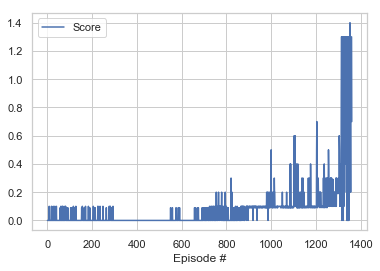

In [13]:
plot_scores(scores)

### Watch Smart Agent

In [1]:
from maddpg_agent import MultiAgent
from model import Actor
from model import Critic
from replay_buffer import ReplayBuffer
from noise import OUNoise
from unity_env_wrapper import EnvMultipleWrapper
from unityagents import UnityEnvironment
import torch

unity_env = UnityEnvironment(file_name="Tennis.app")
env = EnvMultipleWrapper(env=unity_env, train_mode=False)

buffer_size = int(1e5)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate_actor = 1e-4
learning_rate_critic = 1e-3
seed = 2
episodes_before_train = 300
batch_size = 256

action_dim = env.action_size
state_dim = env.state_size
num_agents = env.num_agents

def create_actor():
    return Actor(
        state_dim=state_dim,
        action_dim=action_dim,
        fc1_units=400,
        fc2_units=300,
        seed=seed)

def create_critic():
    return Critic(
        state_dim=state_dim * num_agents,
        action_dim=action_dim * num_agents,
        fc1_units=400,
        fc2_units=300,
        seed=seed)

def create_noise():
    return OUNoise(size=action_dim, seed=seed)

replay_buffer = ReplayBuffer(buffer_size=buffer_size, seed=seed)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [2]:
agent = MultiAgent(
    num_agents=num_agents,
    create_actor=create_actor,
    create_critic=create_critic,
    replay_buffer=replay_buffer,
    create_noise=create_noise,
    state_dim=state_dim,
    action_dim=action_dim,
    episodes_before_train=episodes_before_train,
    device=device,
    lr_actor=learning_rate_actor,
    lr_critic=learning_rate_critic,
    batch_size=batch_size,
    discount=0.99,
    tau=1e-3,
    noise_reduction=0.99,
    seed=seed)

In [4]:
from torchsummary import summary
summary(agent.agents[0].actor, (state_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1                   [-1, 24]              48
            Linear-2                  [-1, 400]          10,000
            Linear-3                  [-1, 300]         120,300
            Linear-4                    [-1, 2]             602
Total params: 130,950
Trainable params: 130,950
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.50
Estimated Total Size (MB): 0.51
----------------------------------------------------------------


/anaconda3/envs/drlnd/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [5]:
summary(agent.agents[0].critic, [(state_dim * num_agents,), (action_dim * num_agents, )])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1                   [-1, 48]              96
            Linear-2                  [-1, 400]          19,600
            Linear-3                  [-1, 300]         121,500
            Linear-4                    [-1, 1]             301
Total params: 141,497
Trainable params: 141,497
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.54
Estimated Total Size (MB): 0.55
----------------------------------------------------------------


In [15]:
for i, agent_i in enumerate(agent.agents):
    agent_i.actor.load_state_dict(torch.load(f"checkpoint_actor_{i}.pth"))
    agent_i.critic.load_state_dict(torch.load(f"checkpoint_critic_{i}.pth"))

In [18]:
states = env.reset()
score = np.zeros(env.num_agents)
for t in range(5000):
    actions = agent.act(states, add_noise=False)
    next_states, rewards, dones = env.step(actions)
    states = next_states
    
    score += rewards
    if np.any(dones):
        break
        
print(np.max(score))

2.600000038743019
